In [4]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 순서

데이터 확인 -> 프로세싱 -> 데이터 셋 분리 및 모델구성 -> 학습 -> 예측 확인
정도 진행하면 된다.

In [5]:
dataset = pd.read_csv("./data/car_evaluation.csv")
dataset.head()

,price,maint,doors,persons,lug_capacity,safety,output
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


<AxesSubplot:ylabel='output'>

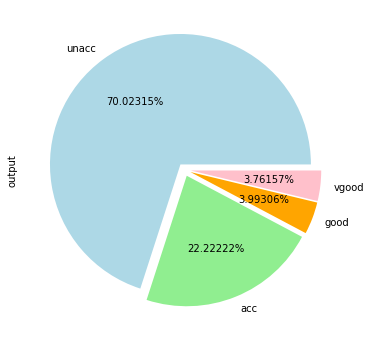

In [7]:
fig_size = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = [8, 6]
dataset.output.value_counts().plot(
    kind="pie", 
    autopct="%0.05f%%", 
    colors = ["lightblue", "lightgreen", "orange", "pink"], 
    explode = (0.05, 0.05, 0.05, 0.05)
)


In [24]:
categorical_columns = ['price', 'maint', 'doors', 'persons', 'lug_capacity', 'safety']

for category in categorical_columns:
    dataset[category] = dataset[category].astype('category') # 범주형 데이터(category)로 변환

price = dataset.price.cat.codes.values # 1차원 numpy.ndarray로 변환
maint = dataset.maint.cat.codes.values
doors = dataset.doors.cat.codes.values
persons = dataset.persons.cat.codes.values
lug_capacity = dataset['lug_capacity'].cat.codes.values
safety = dataset.safety.cat.codes.values

categorical_data = np.stack([price, maint, doors, persons, lug_capacity, safety], axis=1)
categorical_data[:5]

array([[3, 3, 0, 0, 2, 1],
       [3, 3, 0, 0, 2, 2],
       [3, 3, 0, 0, 2, 0],
       [3, 3, 0, 0, 1, 1],
       [3, 3, 0, 0, 1, 2]], dtype=int8)

In [25]:
categorical_data = torch.tensor(categorical_data, dtype=torch.int64) # numpy.ndarray를 torch.tensor로 변환
categorical_data[:5]

tensor([[3, 3, 0, 0, 2, 1],
        [3, 3, 0, 0, 2, 2],
        [3, 3, 0, 0, 2, 0],
        [3, 3, 0, 0, 1, 1],
        [3, 3, 0, 0, 1, 2]])

In [30]:
outputs = pd.get_dummies(dataset.output) # 범주형 데이터를 one hot vector 마냥 나머지 0, 해당시 1로 변환함
outputs = outputs.values
outputs = torch.tensor(outputs).flatten() # 2차원 numpy.ndarray를 1차원 numpy.ndarray로 변환

print(categorical_data.shape)
print(outputs.shape)

torch.Size([1728, 6])
torch.Size([6912])


In [33]:
# [4, 4, 4, 3, 3, 3]
categorical_column_sizes = [len(dataset[column].cat.categories) for column in categorical_columns]

# 임베딩 크기 -> 규칙은 없지만 보통 고유값 / 2의 크기로 임베딩하곤 함
# [(4, 2), (4, 2), (4, 2), (3, 2), (3, 2), (3, 2)]
categorical_embedding_size = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_column_sizes]

In [34]:
total_record = 1728
test_record = int(total_record * 0.2) # 전체 중 20%를 테스트 데이터로 사용

categorical_train_data = categorical_data[:total_record - test_record]
categorical_test_data = categorical_data[total_record - test_record:total_record]
train_outputs = outputs[:total_record - test_record]
test_outputs = outputs[total_record - test_record:total_record]

print(len(categorical_train_data))
print(len(train_outputs))
print(len(categorical_test_data))
print(len(test_outputs))

1383
1383
345
345


In [35]:
class Model(nn.Module):
    def __init__(self, embedding_size, output_size, layers, p=0.4):
        super().__init__()
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)
        
        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols 

        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i)) # 배치 정규화로 사용
            all_layers.append(nn.Dropout(p)) # dropout 시행
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))
        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_categorical):
        embeddings = []
        for i,e in enumerate(self.all_embeddings):
            embeddings.append(e(x_categorical[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x)
        x = self.layers(x)
        return x

In [36]:
model = Model(categorical_embedding_size, 4, [200, 100, 50], p=0.4)
print(model)

Model(
  (all_embeddings): ModuleList(
    (0): Embedding(4, 2)
    (1): Embedding(4, 2)
    (2): Embedding(4, 2)
    (3): Embedding(3, 2)
    (4): Embedding(3, 2)
    (5): Embedding(3, 2)
  )
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=50, out_features=4, bias=True)
  )
)


In [37]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [39]:
epochs = 500
aggregated_loss = []
train_outputs = train_outputs.to(dtype=torch.int64)

for i in range(epochs):
    i += 1
    y_pred = model(categorical_train_data)
    single_loss = loss_function(y_pred, train_outputs)
    aggregated_loss.append(single_loss)

    if i % 25 == 1:
        print(f"epoch: {i} loss: {single_loss.item()}")
    
    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()
    
print(f"epoch: {i} loss: {single_loss.item()}")

epoch: 1 loss: 0.5562452077865601
epoch: 26 loss: 0.55597323179245
epoch: 51 loss: 0.5596910119056702
epoch: 76 loss: 0.5509586930274963
epoch: 101 loss: 0.5547242164611816
epoch: 126 loss: 0.5601402521133423
epoch: 151 loss: 0.5496437549591064
epoch: 176 loss: 0.5434374213218689
epoch: 201 loss: 0.5366055369377136
epoch: 226 loss: 0.5373678803443909
epoch: 251 loss: 0.5324512124061584
epoch: 276 loss: 0.527302086353302
epoch: 301 loss: 0.5231626033782959
epoch: 326 loss: 0.5215014815330505
epoch: 351 loss: 0.5263146162033081
epoch: 376 loss: 0.5150207877159119
epoch: 401 loss: 0.5121834874153137
epoch: 426 loss: 0.5163354277610779
epoch: 451 loss: 0.4961206614971161
epoch: 476 loss: 0.49788349866867065
epoch: 500 loss: 0.49910667538642883


In [40]:
test_outputs = test_outputs.to(dtype=torch.int64)
with torch.no_grad():
    y_val = model(categorical_test_data)
    loss = loss_function(y_val, test_outputs)

print(f"test loss: {loss.item()}")

test loss: 0.48727986216545105


In [41]:
print(y_val[:5])

tensor([[ 3.0005,  1.9214, -4.8047, -4.7861],
        [ 2.0013,  1.7730, -3.8325, -3.6925],
        [ 5.0250,  1.6116, -6.0226, -6.6696],
        [ 2.8202,  1.9594, -4.9437, -4.8782],
        [ 3.7513,  2.6322, -6.4372, -6.5457]])
